<font color="red">

## Задачи:

1. Провести анализ компонент временного ряда с помощью библиотеки Prophet.
2. Сравнить предсказание библиотеки Prophet с истинными значениями на тестовой выборке.
3. Сделать прогнозы модели на различные временные периоды.

</font>


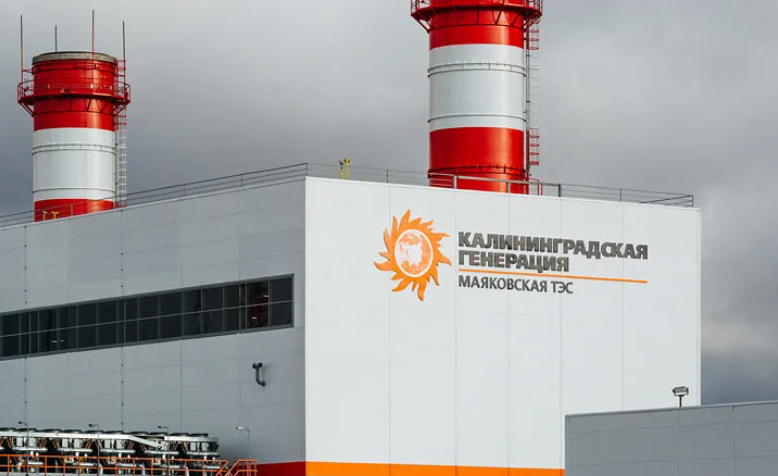

## Загрузка библиотек

In [ ]:
pip install prophet

In [ ]:
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import timedelta

from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

import warnings
warnings.filterwarnings('ignore')

## Импорт данных

In [ ]:
file_path = '/content/drive/My Drive/Университет/Intelligent_analysis/dataset.xls'
df = pd.read_excel(file_path)

# Преобразуем дату во времянной формат
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

# А часы в целочисленный
df['time'] = df['time'].astype(int)

# Добавляем информацию о времени суток из столбца 'time' во столбец "date"
df['date'] = df['date'] + pd.to_timedelta(df['time'], unit='h') + pd.to_timedelta('30 minutes')

In [ ]:
# Создаём копию для дневных ресёчей
df_day = df.copy()

# Дропаем лишнее для суток поле time, а также текстовые поля, которые не можем агрегировать
columns_to_drop = ['time', 'weather_pred', 'weather_fact', 'temp', 'temp_pred']
df_day = df_day.drop(columns=columns_to_drop)

# Группируем данные по дням и выполняем агрегацию
df_day = df_day.groupby(df_day['date'].dt.date).agg({
    'target': 'sum'
}).reset_index()

# Преобразуем столбец 'date' к типу datetime64[ns], а то после группировки он становится object
df_day['date'] = pd.to_datetime(df_day['date'])

In [ ]:
df_day

,date,target
0,2019-01-01,11126.866
1,2019-01-02,11547.210
2,2019-01-03,12235.564
3,2019-01-04,12763.044
4,2019-01-05,12735.145
...,...,...
1668,2023-07-27,9676.911
1669,2023-07-28,9754.812
1670,2023-07-29,9525.396
1671,2023-07-30,9296.344


In [ ]:
df_day.dtypes

date      datetime64[ns]
target           float64
dtype: object

## EDA

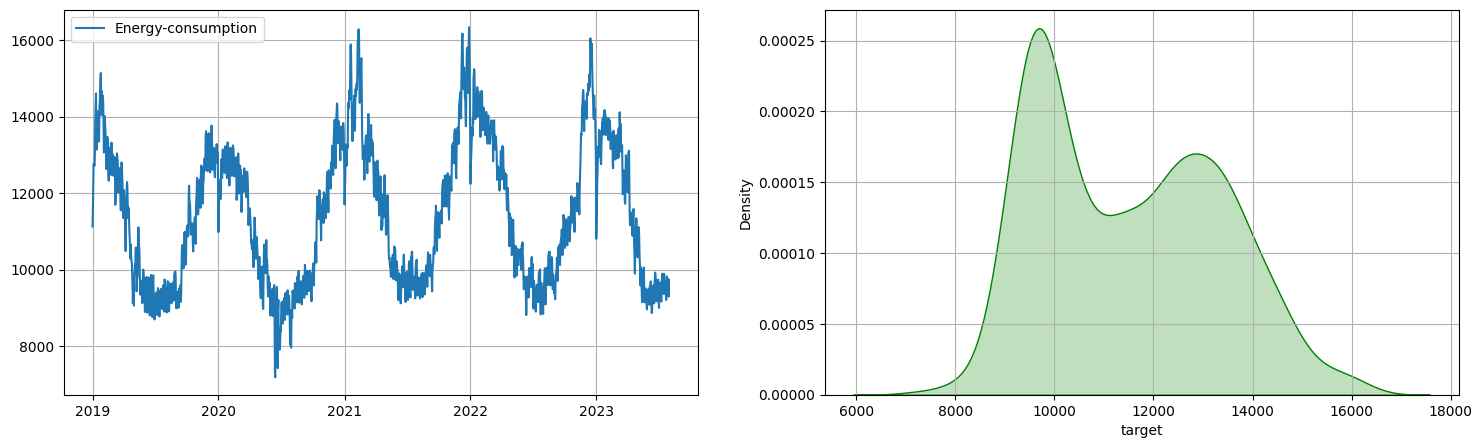

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18,5))

axes[0].plot(df_day.date, df_day.target, label='Energy-consumption')
axes[0].legend(loc="best")
axes[0].grid(True)

sns.kdeplot(df_day['target'], ax=axes[1], color='green', fill=True)
axes[1].grid(True)
plt.show()

In [ ]:
def create_features (data_full, col_date):
    data = data_full.copy()
    data['weekday'] = data[col_date].dt.day_name().astype(cat_type)
    data['quarter'] = data['date'].dt.quarter
    data['month'] = data[col_date].dt.month
    data['year'] = data[col_date].dt.year
    data['date_offset']= (data[col_date].dt.month * 100 + data.date.dt.day - 320) % 1300
    data['season'] = pd.cut(data['date_offset'], [0, 300, 602, 900, 1300], labels=['Spring', 'Summer', 'Fall', 'Winter'])
    return data

cat_type = CategoricalDtype(categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)

df_features = create_features(data_full=df_day, col_date='date')

df_features

,date,target,weekday,quarter,month,year,date_offset,season
0,2019-01-01,11126.866,Tuesday,1,1,2019,1081,Winter
1,2019-01-02,11547.210,Wednesday,1,1,2019,1082,Winter
2,2019-01-03,12235.564,Thursday,1,1,2019,1083,Winter
3,2019-01-04,12763.044,Friday,1,1,2019,1084,Winter
4,2019-01-05,12735.145,Saturday,1,1,2019,1085,Winter
...,...,...,...,...,...,...,...,...
1668,2023-07-27,9676.911,Thursday,3,7,2023,407,Summer
1669,2023-07-28,9754.812,Friday,3,7,2023,408,Summer
1670,2023-07-29,9525.396,Saturday,3,7,2023,409,Summer
1671,2023-07-30,9296.344,Sunday,3,7,2023,410,Summer


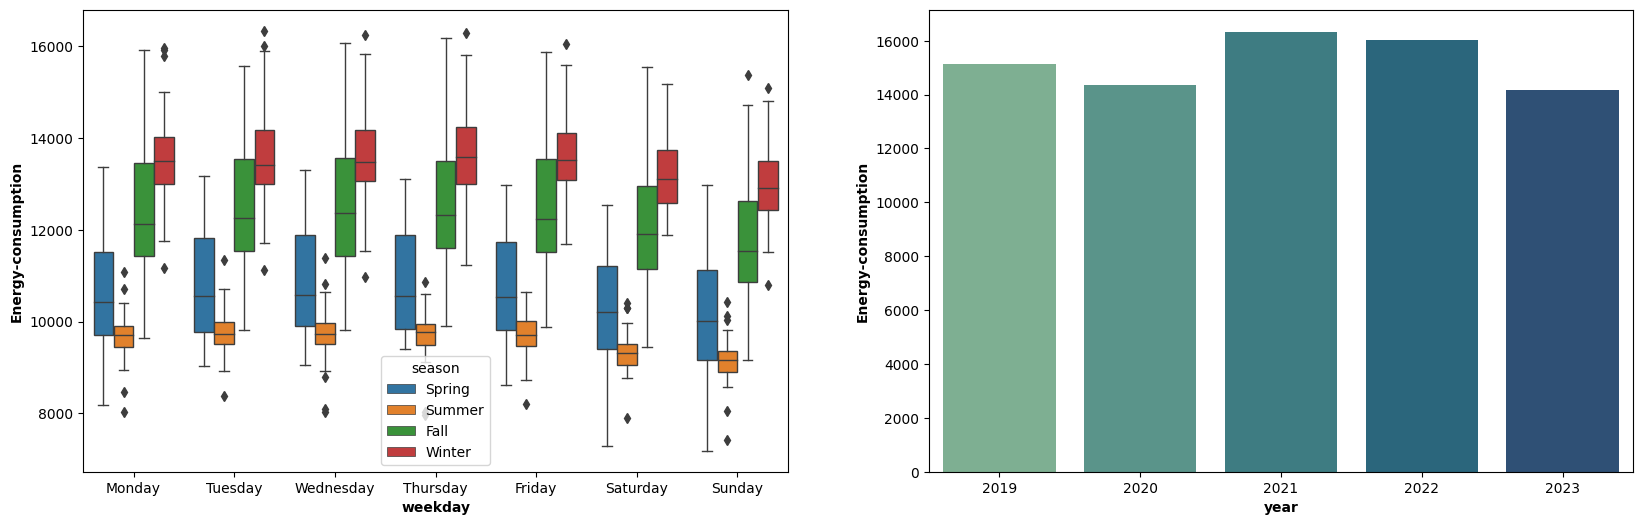

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
sns.boxplot(data=df_features,
            x='weekday',
            y='target',
            hue='season',
            ax=axes [0],
            linewidth=1)
axes[0].set_xlabel('weekday', fontweight='bold')
axes[0].set_ylabel('Energy-consumption', fontweight='bold')

yearAggregated = pd.DataFrame(df_features.groupby("year")["target"].max()).reset_index().sort_values('target')
sns.barplot(data=yearAggregated, x="year", y="target", palette='crest')
axes[1].set_xlabel('year', fontweight='bold')
axes[1].set_ylabel('Energy-consumption', fontweight='bold')

plt.show()

In [ ]:
df_day = df_day.rename(columns={'date': 'ds', 'target': 'y'})
model = Prophet()
model.fit(df_day)
predict = model.predict(df_day)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpktvxudib/8fw6czm2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpktvxudib/qrx8lk9o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21509', 'data', 'file=/tmp/tmpktvxudib/8fw6czm2.json', 'init=/tmp/tmpktvxudib/qrx8lk9o.json', 'output', 'file=/tmp/tmpktvxudib/prophet_model5y6dv10o/prophet_model-20240106142910.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:29:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:29:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


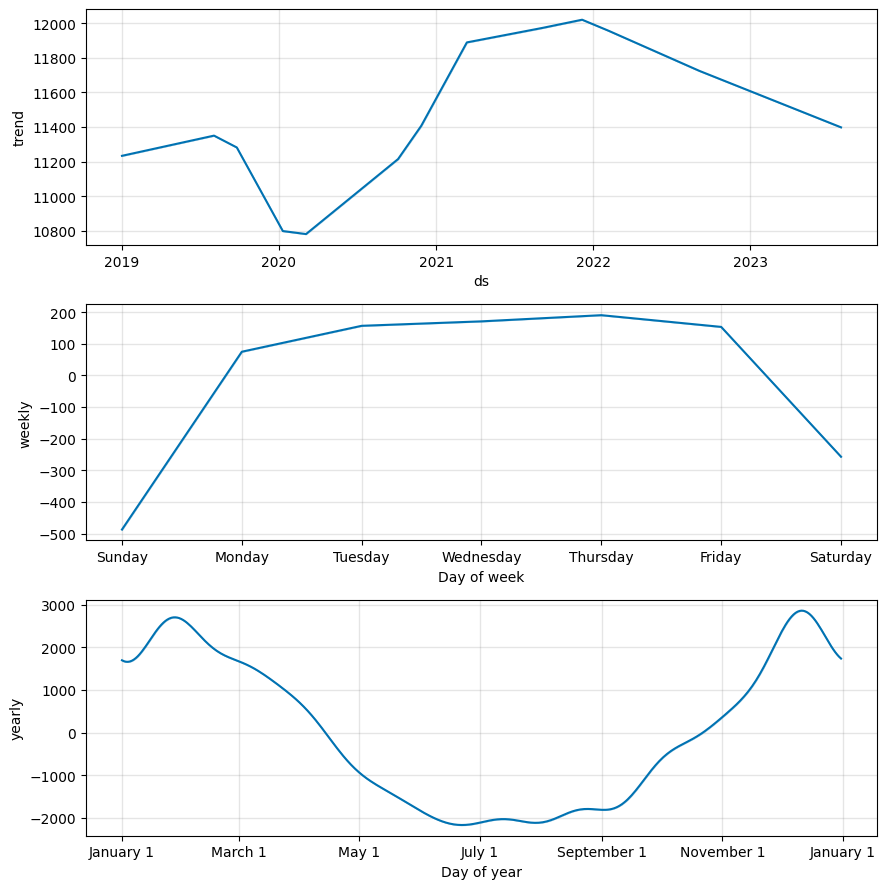

In [ ]:
# Разложение временного ряда на компоненты
fig = model.plot_components(predict)
plt.show()

## Прогноз на тестовой выборке

In [ ]:
df_day = df_day.rename(columns={'date': 'ds', 'target': 'y'})

In [ ]:
test_size = int(df_day.shape[0]*0.1)

train_df = df_day.iloc[:-test_size]
test_df = df_day.iloc[-test_size:]
print(train_df.shape)
print(test_df.shape)

(1506, 2)
(167, 2)


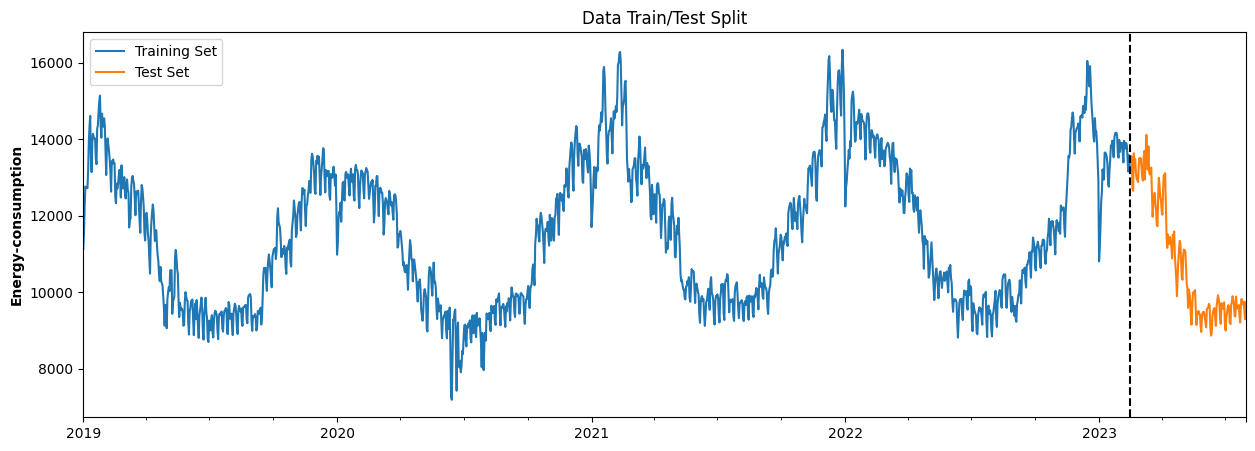

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))

train_df.set_index('ds'). plot (ax=ax,
                                label='Train',
                                title='Data Train/Test Split')
test_df.set_index('ds').plot(ax=ax, label='Test')
ax.axvline(train_df['ds'] [-1:].values, color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
ax.set_ylabel('Energy-consumption', fontweight='bold')
ax.set_xlabel('')
plt.show()

In [ ]:
model = Prophet()
model.fit(train_df)
predict = model.predict(test_df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpktvxudib/73s09r8f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpktvxudib/kv15bwk0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95708', 'data', 'file=/tmp/tmpktvxudib/73s09r8f.json', 'init=/tmp/tmpktvxudib/kv15bwk0.json', 'output', 'file=/tmp/tmpktvxudib/prophet_model7gq0limu/prophet_model-20240106154811.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:48:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:48:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


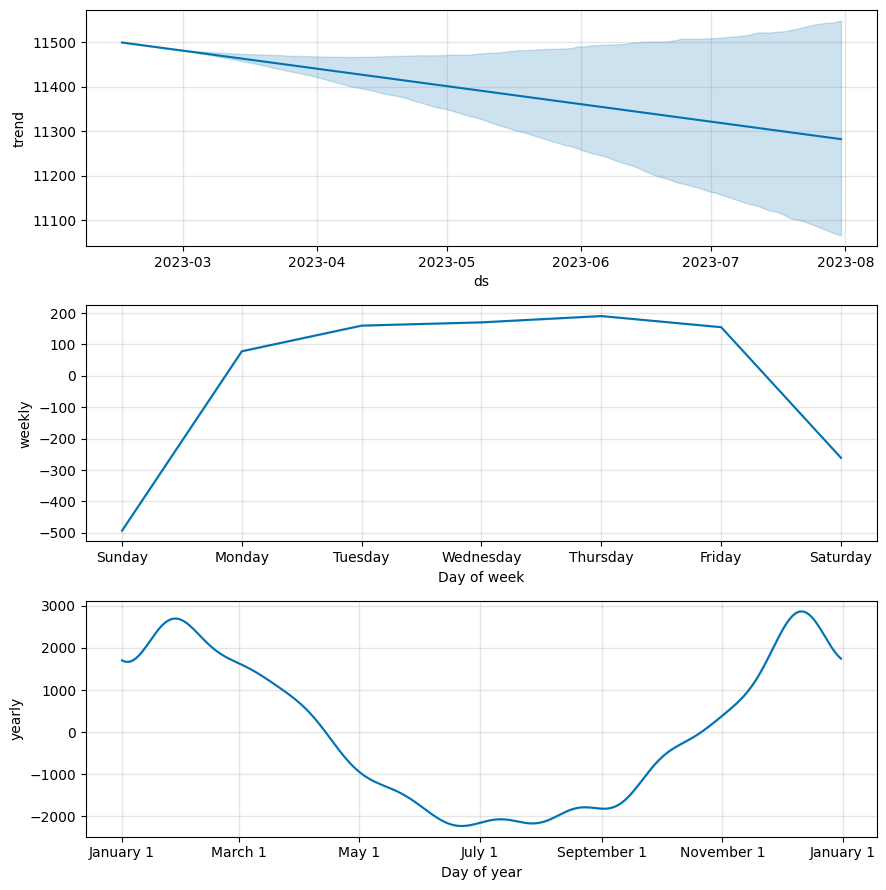

In [ ]:
# Разложение временного ряда на компоненты на тестовой выборке
fig = model.plot_components(predict)
plt.show()

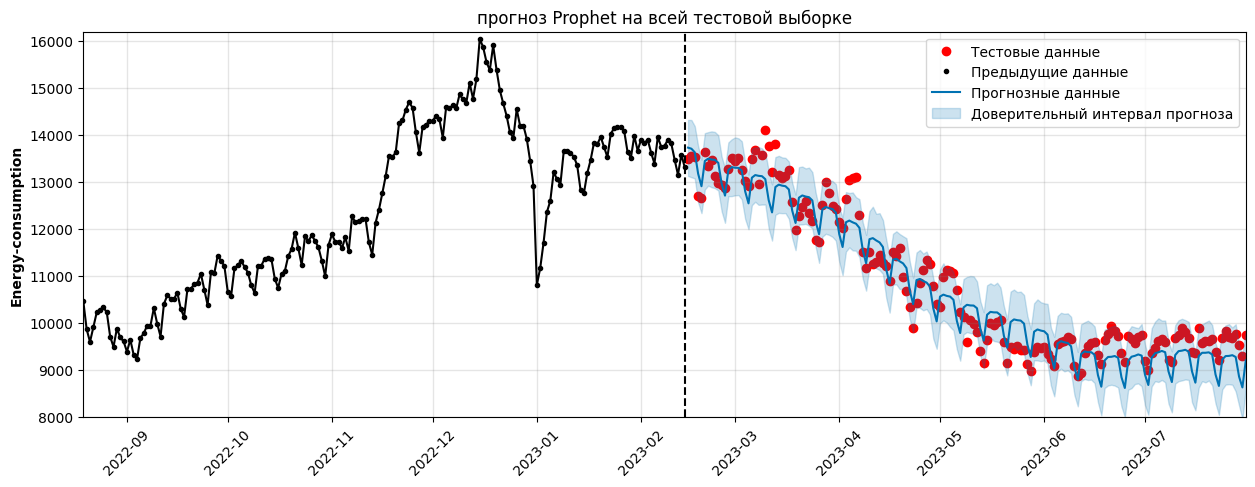

In [ ]:
f, ax = plt.subplots(figsize=(15,5))

ax.scatter(test_df.ds, test_df['y'], color='r')
fig = model.plot(predict, ax=ax)

last_31_days = train_df['ds'][-180:].values
last_day = test_df['ds'][-1:].values

ax.set_xlim(left=last_31_days.min(), right=last_day.max())
ax.set_ylim(8_000, 16_200)

ax.plot(train_df['ds'], train_df['y'], color='black', linestyle='-')
ax.axvline(train_df['ds'] [-1:].values, color='black', ls='--')

ax.set_title('прогноз Prophet на всей тестовой выборке')
ax.set_ylabel('Energy-consumption', fontweight='bold')
ax.set_xlabel('')
plt.xticks(rotation=45)
ax.legend(['Тестовые данные', 'Предыдущие данные', 'Прогнозные данные', 'Доверительный интервал прогноза'], loc='upper right')

plt.show()

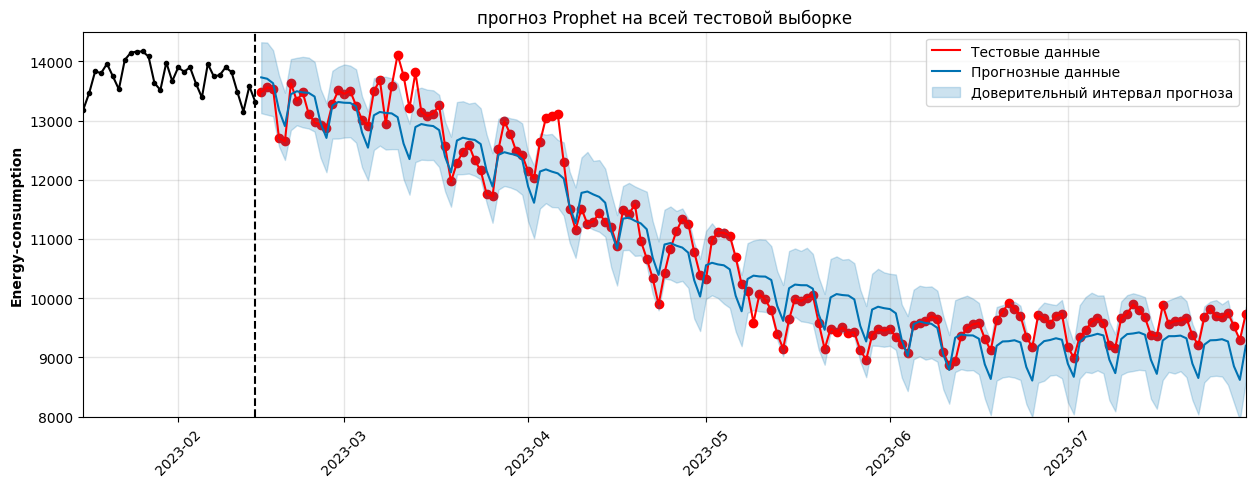

In [ ]:
f, ax = plt.subplots(figsize=(15,5))

ax.plot(test_df['ds'], test_df['y'], color='r', linestyle='-')
ax.scatter(test_df.ds, test_df['y'], color='r')
fig = model.plot(predict, ax=ax)

last_31_days = train_df['ds'][-30:].values
last_day = test_df['ds'][-1:].values

ax.set_xlim(left=last_31_days.min(), right=last_day.max())
ax.set_ylim(8_000, 14_500)

ax.plot(train_df['ds'], train_df['y'], color='black', linestyle='-')
ax.axvline(train_df['ds'] [-1:].values, color='black', ls='--')

ax.set_title('прогноз Prophet на всей тестовой выборке')
ax.set_ylabel('Energy-consumption', fontweight='bold')
ax.set_xlabel('')
plt.xticks(rotation=45)
ax.legend(['Тестовые данные', '_nolegend_', '_nolegend_', 'Прогнозные данные', 'Доверительный интервал прогноза'], loc='upper right')

plt.show()

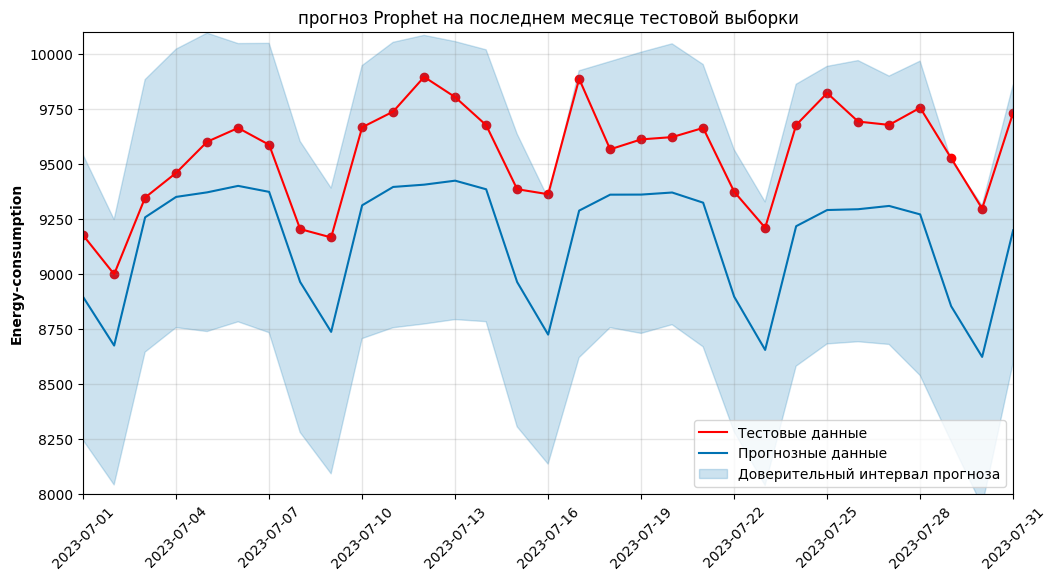

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(test_df['ds'], test_df['y'], color='r', linestyle='-')
ax.scatter(test_df['ds'], test_df['y'], color='r')
fig = model.plot(predict, ax=ax)

last_31_days = test_df['ds'][-31:].values
last_day = test_df['ds'][-1:].values

ax.set_xlim(left=last_31_days.min(), right=last_day.max())
ax.set_ylim(8_000, 10_100)

ax.set_title('прогноз Prophet на последнем месяце тестовой выборки')
ax.set_ylabel('Energy-consumption', fontweight='bold')
ax.set_xlabel('')
plt.xticks(rotation=45)
ax.legend(['Тестовые данные', '_nolegend_', '_nolegend_', 'Прогнозные данные', 'Доверительный интервал прогноза'], loc='lower right')

plt.show()

## Метрики ошибок

In [ ]:
def evaluate_model(df_day, model, test_size):
    train_df = df_day.iloc[:-test_size]
    test_df = df_day.iloc[-test_size:]

    df_test_null = test_df.copy()
    df_test_null['y'] = None

    df_predict = pd.concat([train_df, df_test_null])
    predict = model.predict(df_predict)

    MAE = mean_absolute_error(y_true=test_df['y'], y_pred=predict['yhat'][train_df.shape[0]:])
    MSE = mean_squared_error(y_true=test_df['y'], y_pred=predict['yhat'][train_df.shape[0]:])
    RMSE = np.sqrt(MSE)
    MAPE = mean_absolute_percentage_error(y_true=test_df['y'], y_pred=predict['yhat'][train_df.shape[0]:])
    R2 = r2_score(y_true=test_df['y'], y_pred=predict['yhat'][train_df.shape[0]:])

    text_score = f"Метрики качества обученной модели:" \
                f"\nMean Absolute Error (MAE): {MAE:_.2f}" \
                f"\nRoot Mean Squared Error (RMSE): {RMSE:_.2f}" \
                f"\nMean Absolute Percentage Error (MAPE): {MAPE:_.2f}%" \
                f"\nR-squared (R2): {R2:_.2f} \n"

    print(text_score)

In [ ]:
test_sizes = [7, 14, 31, 90, 180, 366]

for test_size in test_sizes:
  print(f'\n\nПрогноз энергопотребления на {test_size} дней: \n')
  evaluate_model(df_day, model, test_size)
  print('---' * 30)



Прогноз энергопотребления на 7 дней: 

Метрики качества обученной модели:
Mean Absolute Error (MAE): 351.12
Root Mean Squared Error (RMSE): 368.51
Mean Absolute Percentage Error (MAPE): 0.04%
R-squared (R2): -4.00 

------------------------------------------------------------------------------------------


Прогноз энергопотребления на 14 дней: 

Метрики качества обученной модели:
Mean Absolute Error (MAE): 269.58
Root Mean Squared Error (RMSE): 304.56
Mean Absolute Percentage Error (MAPE): 0.03%
R-squared (R2): -2.12 

------------------------------------------------------------------------------------------


Прогноз энергопотребления на 31 дней: 

Метрики качества обученной модели:
Mean Absolute Error (MAE): 227.74
Root Mean Squared Error (RMSE): 266.29
Mean Absolute Percentage Error (MAPE): 0.02%
R-squared (R2): -0.34 

------------------------------------------------------------------------------------------


Прогноз энергопотребления на 90 дней: 

Метрики качества обученной мо

## Прогноз

In [ ]:
df_day = df_day.rename(columns={'date': 'ds', 'target': 'y'})

model_full = Prophet(changepoint_prior_scale=0.4)
model_full.fit(df_day)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpktvxudib/9uwml6ek.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpktvxudib/8p3geur1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38961', 'data', 'file=/tmp/tmpktvxudib/9uwml6ek.json', 'init=/tmp/tmpktvxudib/8p3geur1.json', 'output', 'file=/tmp/tmpktvxudib/prophet_modeljx8nhi8x/prophet_model-20240106164255.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:42:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:42:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


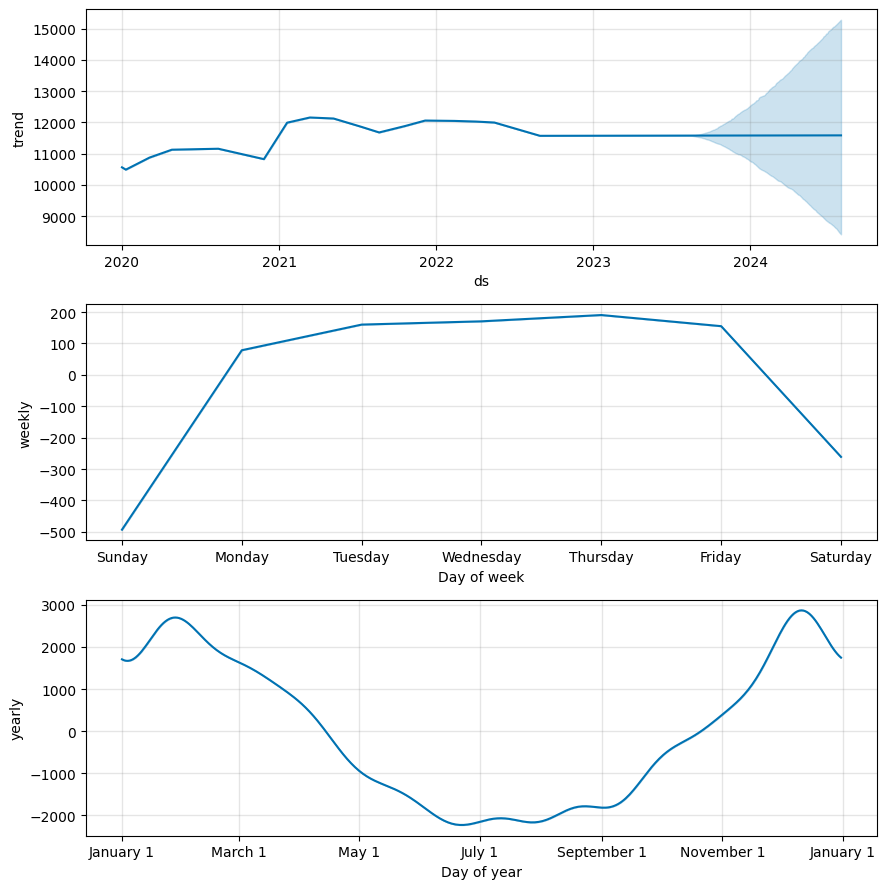

In [ ]:
# Разложение временного ряда на компоненты с пронозом на будущее
future_all = model_full.make_future_dataframe(periods=365, freq='D')
future = future_all.iloc[365:]
forecast = model_full.predict(future)

fig = model.plot_components(forecast)
plt.show()

### На 2 недели

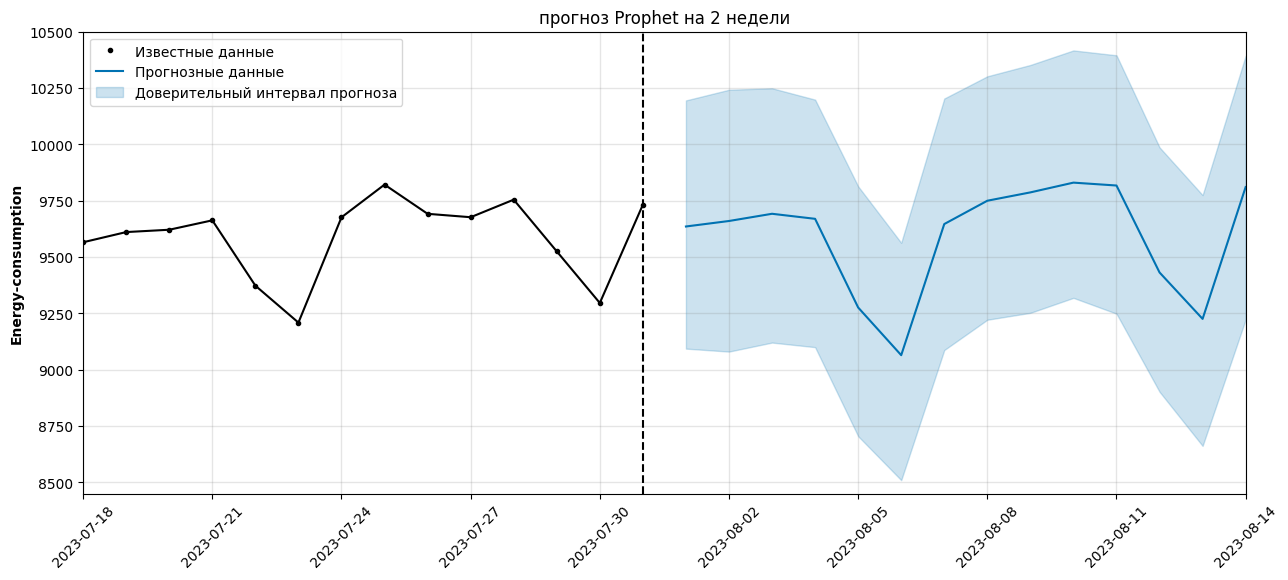

In [ ]:
future_all = model_full.make_future_dataframe(periods=14, freq='D')
future = future_all.iloc[-14:]
forecast = model_full.predict(future)

fig, ax = plt.subplots(figsize=(15, 6))
fig = model_full.plot(forecast, ax=ax)

last_14_days = df_day['ds'][-14:].values
last_day = forecast['ds'][-1:].values

ax.set_xlim(left=last_14_days.min(), right=last_day.max())
ax.set_ylim(8_450, 10_500)

ax.plot(df_day['ds'], df_day['y'], color='black', linestyle='-')
ax.axvline(df_day['ds'] [-1:].values, color='black', ls='--')

ax.set_title('прогноз Prophet на 2 недели')
ax.set_ylabel('Energy-consumption', fontweight='bold')
ax.set_xlabel('')
plt.xticks(rotation=45)
ax.legend(['Известные данные', 'Прогнозные данные', 'Доверительный интервал прогноза'], loc='upper left')

plt.show()

### На 1 месяц

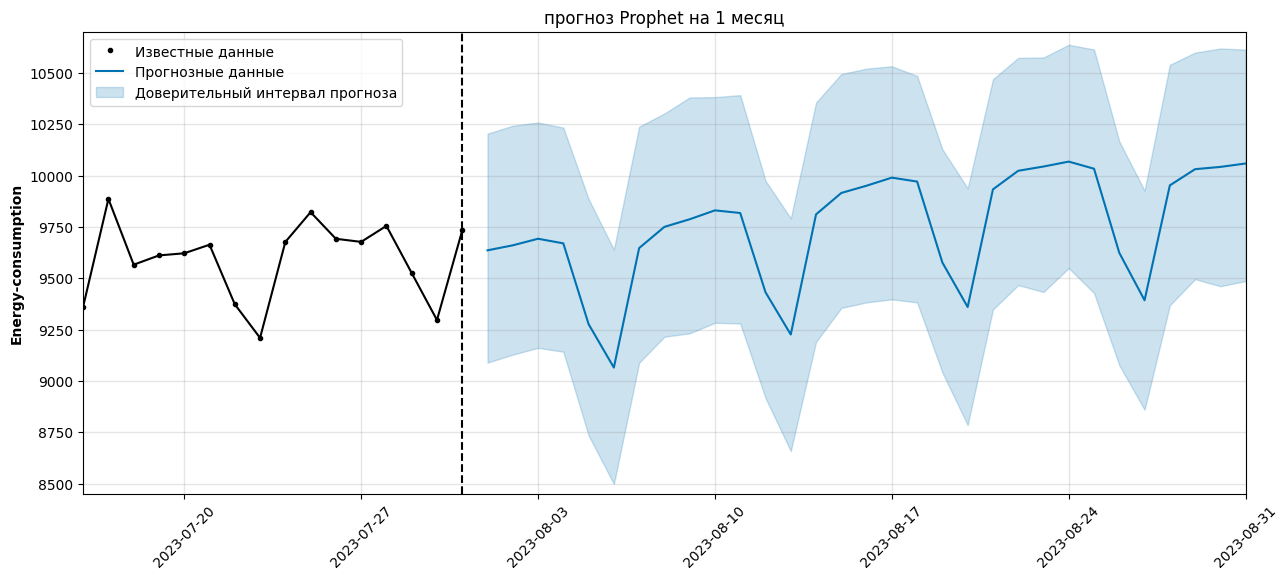

In [ ]:
future_all = model_full.make_future_dataframe(periods=31, freq='D')
future = future_all.iloc[-31:]
forecast = model_full.predict(future)

fig, ax = plt.subplots(figsize=(15, 6))
fig = model_full.plot(forecast, ax=ax)

last_31_days = df_day['ds'][-31//2:].values
last_day = forecast['ds'][-1:].values

ax.set_xlim(left=last_31_days.min(), right=last_day.max())
ax.set_ylim(8_450, 10_700)

ax.plot(df_day['ds'], df_day['y'], color='black', linestyle='-')
ax.axvline(df_day['ds'] [-1:].values, color='black', ls='--')

ax.set_title('прогноз Prophet на 1 месяц')
ax.set_ylabel('Energy-consumption', fontweight='bold')
ax.set_xlabel('')
plt.xticks(rotation=45)
ax.legend(['Известные данные', 'Прогнозные данные', 'Доверительный интервал прогноза'], loc='upper left')

plt.show()

### На 3 месяца

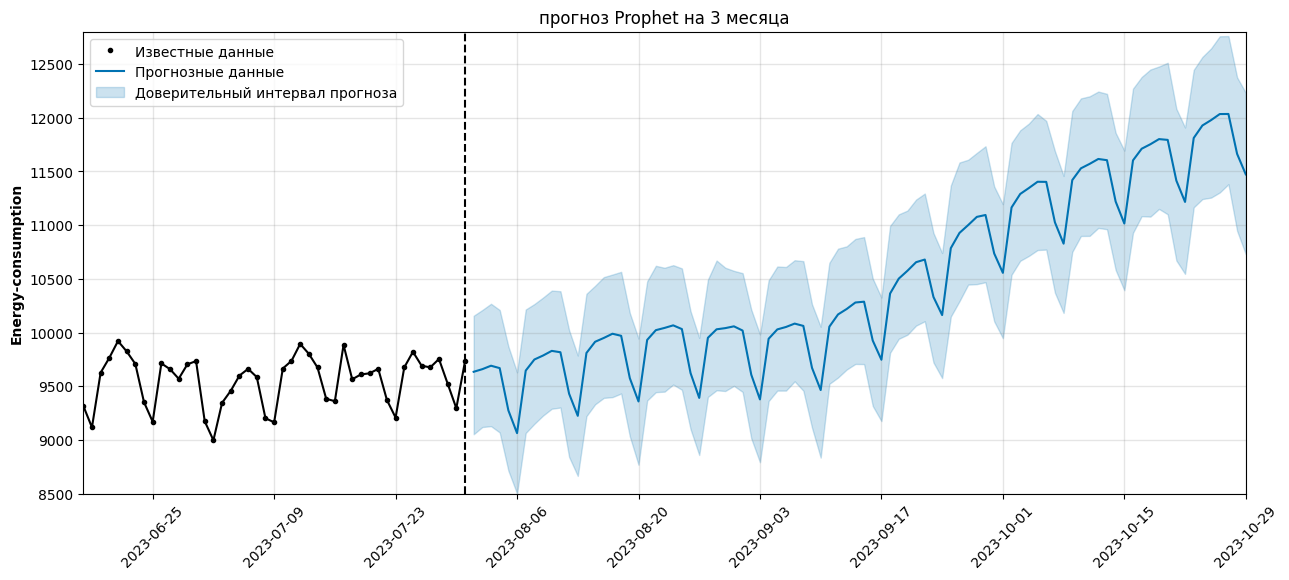

In [ ]:
future_all = model_full.make_future_dataframe(periods=90, freq='D')
future = future_all.iloc[-90:]
forecast = model_full.predict(future)

fig, ax = plt.subplots(figsize=(15, 6))
fig = model_full.plot(forecast, ax=ax)

last_90_days = df_day['ds'][-90//2:].values
last_day = forecast['ds'][-1:].values

ax.set_xlim(left=last_90_days.min(), right=last_day.max())
ax.set_ylim(8_500, 12_800)

ax.plot(df_day['ds'], df_day['y'], color='black', linestyle='-')
ax.axvline(df_day['ds'] [-1:].values, color='black', ls='--')

ax.set_title('прогноз Prophet на 3 месяца')
ax.set_ylabel('Energy-consumption', fontweight='bold')
ax.set_xlabel('')
plt.xticks(rotation=45)
ax.legend(['Известные данные', 'Прогнозные данные', 'Доверительный интервал прогноза'], loc='upper left')

plt.show()

### На 6 месяцев

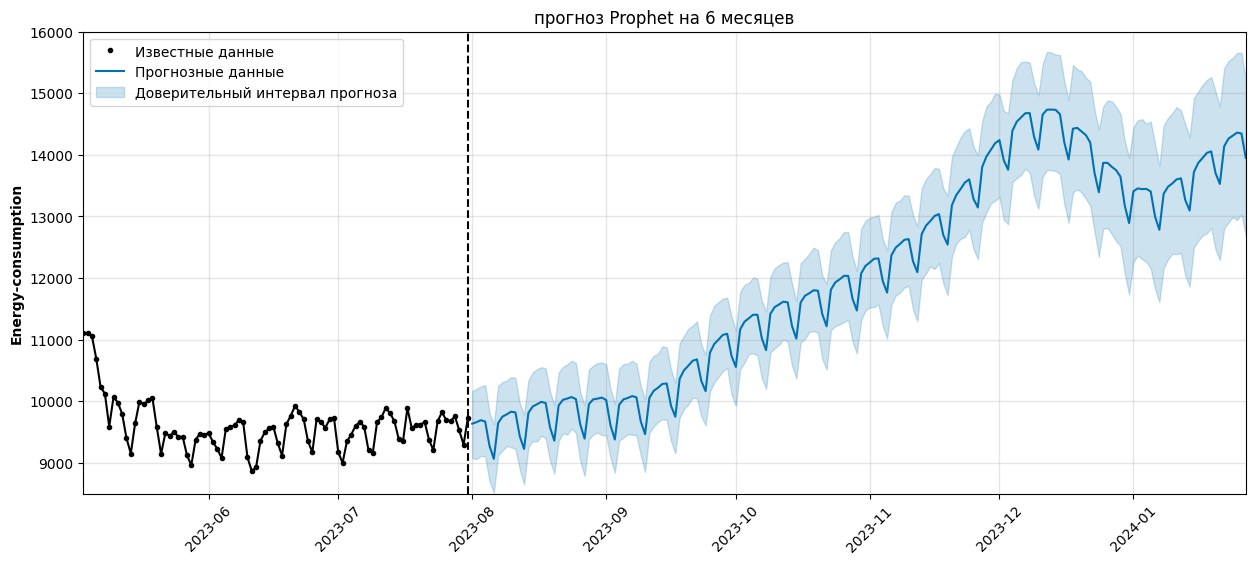

In [ ]:
future_all = model_full.make_future_dataframe(periods=180, freq='D')
future = future_all.iloc[-180:]
forecast = model_full.predict(future)

fig, ax = plt.subplots(figsize=(15, 6))
fig = model_full.plot(forecast, ax=ax)

last_180_days = df_day['ds'][-180//2:].values
last_day = forecast['ds'][-1:].values

ax.set_xlim(left=last_180_days.min(), right=last_day.max())
ax.set_ylim(8_500, 16_000)

ax.plot(df_day['ds'], df_day['y'], color='black', linestyle='-')
ax.axvline(df_day['ds'] [-1:].values, color='black', ls='--')

ax.set_title('прогноз Prophet на 6 месяцев')
ax.set_ylabel('Energy-consumption', fontweight='bold')
ax.set_xlabel('')
plt.xticks(rotation=45)
ax.legend(['Известные данные', 'Прогнозные данные', 'Доверительный интервал прогноза'], loc='upper left')

plt.show()

### На 1 год

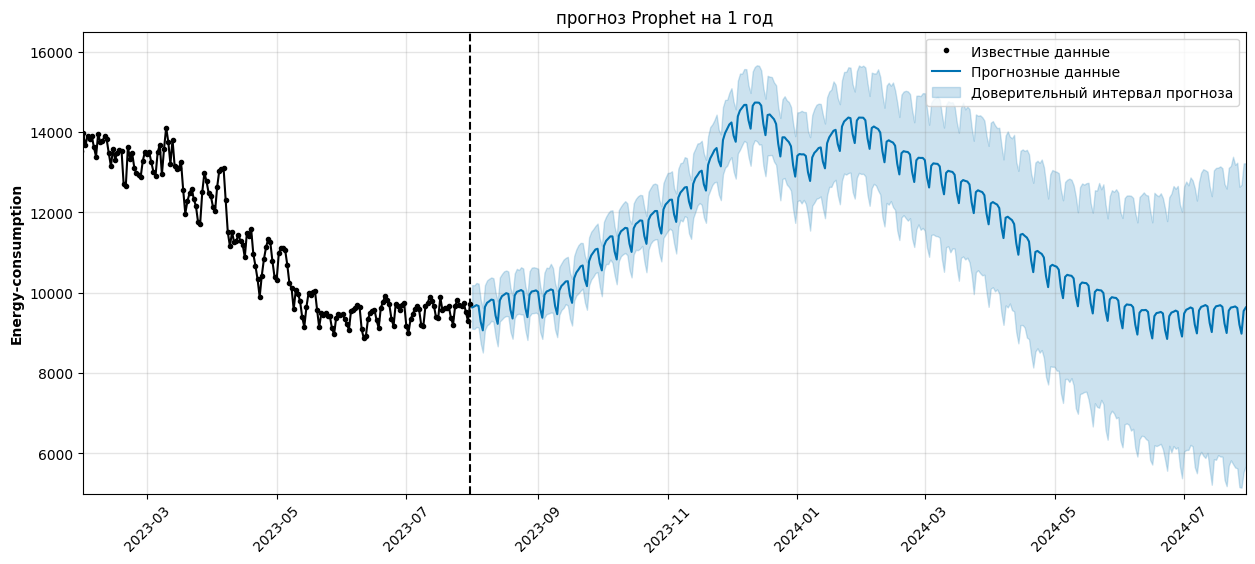

In [ ]:
future_all = model_full.make_future_dataframe(periods=365, freq='D')
future = future_all.iloc[-365:]
forecast = model_full.predict(future)

fig, ax = plt.subplots(figsize=(15, 6))
fig = model_full.plot(forecast, ax=ax)

last_365_days = df_day['ds'][-365//2:].values
last_day = forecast['ds'][-1:].values

ax.set_xlim(left=last_365_days.min(), right=last_day.max())
ax.set_ylim(5_000, 16_500)

ax.plot(df_day['ds'], df_day['y'], color='black', linestyle='-')
ax.axvline(df_day['ds'] [-1:].values, color='black', ls='--')

ax.set_title('прогноз Prophet на 1 год')
ax.set_ylabel('Energy-consumption', fontweight='bold')
ax.set_xlabel('')
plt.xticks(rotation=45)
ax.legend(['Известные данные', 'Прогнозные данные', 'Доверительный интервал прогноза'], loc='upper right')

plt.show()

## Summary

<span style="color:blue">

---

* Библиотека Prophet достаточно хорошо предсказывает поведение временного ряда, у которого есть закономерности в поведении.
* Благодаря данной библиотеки возможно предсказать не только средние значения в будущем, как в наивных моделях, но и вполне неплохо спрогнозировать циклические отклонения и тренды.
* Метрики ошибок улучшаются при прогнозировании на длинные отрезки времени.

---
</span>
